## DC2 Bootstrap Testing with Full Image

In [1]:
import torch
from pathlib import Path
import pickle
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection

output_dir = Path("./bootstrap_test_full_image_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-03-2/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
test_image, test_image_full_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                                            0, 
                                                                            model_path, 
                                                                            lsst_root_dir, 
                                                                            device)
image_lim = test_image.shape[1]

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
bliss_metrics = MetricCollection({
    "detection_performance": bliss_metrics["detection_performance"],
    "detection_performance_star": bliss_metrics["detection_performance_star"],
    "detection_performance_galaxy": bliss_metrics["detection_performance_galaxy"],
})
lsst_metrics = bliss_metrics.clone()

bliss_results = {}
lsst_results = {}

epochs_num = 10
plocs_box_len = 400
plocs_boxes_num = (image_lim // plocs_box_len) ** 2
for epoch in tqdm.tqdm(range(epochs_num), unit="epoch"):
    for i in range(plocs_boxes_num):
        plocs_box_origin = torch.rand(2) * (image_lim - plocs_box_len)
        cur_bliss_full_catalog = bliss_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
        cur_lsst_full_catalog = lsst_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
        cur_target_catalog = test_image_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)

        bliss_matching = matcher.match_catalogs(cur_target_catalog, cur_bliss_full_catalog)
        bliss_metrics.update(cur_target_catalog, cur_bliss_full_catalog, bliss_matching)

        lsst_matching = matcher.match_catalogs(cur_target_catalog, cur_lsst_full_catalog)
        lsst_metrics.update(cur_target_catalog, cur_lsst_full_catalog, lsst_matching)

    for k, v in bliss_metrics.items():
        resutls = v.get_internal_states()
        for k_results, v_results in resutls.items():
            if k_results not in bliss_results:
                    bliss_results[k_results] = []
            bliss_results[k_results].append(v_results.cpu())

    for k, v in lsst_metrics.items():
        resutls = v.get_internal_states()
        for k_results, v_results in resutls.items():
            if k_results not in lsst_results:
                    lsst_results[k_results] = []
            lsst_results[k_results].append(v_results.cpu())

    bliss_metrics.reset()
    lsst_metrics.reset()

bliss_results = {k: torch.stack(v) for k, v in bliss_results.items()}
lsst_results = {k: torch.stack(v) for k, v in lsst_results.items()}

100%|██████████| 10/10 [03:55<00:00, 23.58s/epoch]


In [5]:
def plot_with_error_bars(n_true_sources_1, n_est_sources_1, n_true_matches_1, n_est_matches_1,
                         n_true_sources_2, n_est_sources_2, n_true_matches_2, n_est_matches_2,
                         bin_cutoffs,
                         postfix_str, 
                         model_name_1, model_name_2):
    quantile_points = torch.tensor([0.05, 0.5, 0.95])

    recall_list_1 = (n_true_matches_1 / n_true_sources_1).nan_to_num(0)
    precision_list_1 = (n_est_matches_1 / n_est_sources_1).nan_to_num(0)
    f1_list_1 = (2 * precision_list_1 * recall_list_1 / (precision_list_1 + recall_list_1)).nan_to_num(0)

    recall_list_2 = (n_true_matches_2 / n_true_sources_2).nan_to_num(0)
    precision_list_2 = (n_est_matches_2 / n_est_sources_2).nan_to_num(0)
    f1_list_2 = (2 * precision_list_2 * recall_list_2 / (precision_list_2 + recall_list_2)).nan_to_num(0)

    recall_matrix_1 = recall_list_1.quantile(q=quantile_points, dim=0)
    recall_matrix_1[0, :] = (recall_matrix_1[0, :] - recall_matrix_1[1, :]).abs()
    recall_matrix_1[2, :] = recall_matrix_1[2, :] - recall_matrix_1[1, :]
    precision_matrix_1 = precision_list_1.quantile(q=quantile_points, dim=0)
    precision_matrix_1[0, :] = (precision_matrix_1[0, :] - precision_matrix_1[1, :]).abs()
    precision_matrix_1[2, :] = precision_matrix_1[2, :] - precision_matrix_1[1, :]
    f1_matrix_1 = f1_list_1.quantile(q=quantile_points, dim=0)
    f1_matrix_1[0, :] = (f1_matrix_1[0, :] - f1_matrix_1[1, :]).abs()
    f1_matrix_1[2, :] = f1_matrix_1[2, :] - f1_matrix_1[1, :]

    recall_matrix_2 = recall_list_2.quantile(q=quantile_points, dim=0)
    recall_matrix_2[0, :] = (recall_matrix_2[0, :] - recall_matrix_2[1, :]).abs()
    recall_matrix_2[2, :] = recall_matrix_2[2, :] - recall_matrix_2[1, :]
    precision_matrix_2 = precision_list_2.quantile(q=quantile_points, dim=0)
    precision_matrix_2[0, :] = (precision_matrix_2[0, :] - precision_matrix_2[1, :]).abs()
    precision_matrix_2[2, :] = precision_matrix_2[2, :] - precision_matrix_2[1, :]
    f1_matrix_2 = f1_list_2.quantile(q=quantile_points, dim=0)
    f1_matrix_2[0, :] = (f1_matrix_2[0, :] - f1_matrix_2[1, :]).abs()
    f1_matrix_2[2, :] = f1_matrix_2[2, :] - f1_matrix_2[1, :]

    xlabels = (
        ["[100, " + str(bin_cutoffs[0]) + "]"]
        + [f"[{bin_cutoffs[i]}, {bin_cutoffs[i + 1]}]" for i in range(len(bin_cutoffs) - 1)]
        + ["> " + str(bin_cutoffs[-1])]
    )

    sns.set_theme(style="whitegrid")
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:6]
    graph_tag = f"({postfix_str[1:]})" if postfix_str else ""

    # recall
    recall_fig, recall_axes = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 2]}, sharex="col"
    )

    recall_axes[1].errorbar(
        range(len(xlabels)),
        recall_matrix_1[1, :].tolist(),
        yerr=recall_matrix_1[(0, 2), :],
        fmt="-o",
        color=color_list[0],
        label=f"{model_name_1} Recall {graph_tag}",
    )
    recall_axes[1].errorbar(
        range(len(xlabels)),
        recall_matrix_2[1, :].tolist(),
        yerr=recall_matrix_2[(0, 2), :],
        fmt="-o",
        color=color_list[1],
        label=f"{model_name_2} Recall {graph_tag}",
    )
    recall_axes[1].set_xlabel("Flux")
    recall_axes[1].set_xticks(range(len(xlabels)))
    recall_axes[1].set_xticklabels(xlabels, rotation=45)
    recall_axes[1].legend()

    recall_axes[0].step(
        range(len(xlabels)),
        n_true_sources_1.mean(dim=0).tolist(),
        label=f"# true sources {graph_tag}",
        where="mid",
        color=color_list[2],
    )
    recall_axes[0].step(
        range(len(xlabels)),
        n_true_matches_1.mean(dim=0).tolist(),
        label=f"# {model_name_1} true matches {graph_tag}",
        ls="--",
        where="mid",
        color=color_list[3],
    )
    recall_axes[0].step(
        range(len(xlabels)),
        n_true_matches_2.mean(dim=0).tolist(),
        label=f"# {model_name_2} true matches {graph_tag}",
        ls="--",
        where="mid",
        color=color_list[4],
    )
    count_max = n_true_sources_1.max().item()
    count_ticks = np.round(np.linspace(0, count_max, 5), -3)
    recall_axes[0].set_yticks(count_ticks)
    recall_axes[0].set_ylabel("Count")
    recall_axes[0].legend()
  
    # precision
    precision_fig, precision_axes = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 2]}, sharex="col"
    )

    precision_axes[1].errorbar(
        range(len(xlabels)),
        precision_matrix_1[1, :].tolist(),
        yerr=precision_matrix_1[(0, 2), :],
        fmt="-o",
        color=color_list[0],
        label=f"{model_name_1} Precision {graph_tag}",
    )
    precision_axes[1].errorbar(
        range(len(xlabels)),
        precision_matrix_2[1, :].tolist(),
        yerr=precision_matrix_2[(0, 2), :],
        fmt="-o",
        color=color_list[1],
        label=f"{model_name_2} Precision {graph_tag}",
    )
    precision_axes[1].set_xlabel("Flux")
    precision_axes[1].set_xticks(range(len(xlabels)))
    precision_axes[1].set_xticklabels(xlabels, rotation=45)
    precision_axes[1].legend()

    precision_axes[0].step(
        range(len(xlabels)),
        n_est_sources_1.mean(dim=0).tolist(),
        label=f"# {model_name_1} est sources {graph_tag}",
        where="mid",
        color=color_list[2],
    )
    precision_axes[0].step(
        range(len(xlabels)),
        n_est_sources_2.mean(dim=0).tolist(),
        label=f"# {model_name_2} est sources {graph_tag}",
        where="mid",
        color=color_list[3],
    )
    precision_axes[0].step(
        range(len(xlabels)),
        n_est_matches_1.mean(dim=0).tolist(),
        label=f"# {model_name_1} est matches {graph_tag}",
        ls="--",
        where="mid",
        color=color_list[2],
    )
    precision_axes[0].step(
        range(len(xlabels)),
        n_est_matches_2.mean(dim=0).tolist(),
        label=f"# {model_name_2} est matches {graph_tag}",
        ls="--",
        where="mid",
        color=color_list[3],
    )
    count_max = n_true_sources_1.max().item()
    count_ticks = np.round(np.linspace(0, count_max, 5), -3)
    precision_axes[0].set_yticks(count_ticks)
    precision_axes[0].set_ylabel("Count")
    precision_axes[0].legend()

    precision_fig.tight_layout()

    # f1
    f1_fig, f1_axes = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 2]}, sharex="col"
    )

    f1_axes[1].errorbar(
        range(len(xlabels)),
        f1_matrix_1[1, :].tolist(),
        yerr=f1_matrix_1[(0, 2), :],
        fmt="-o",
        color=color_list[0],
        label=f"{model_name_1} F1 {graph_tag}",
    )
    f1_axes[1].errorbar(
        range(len(xlabels)),
        f1_matrix_2[1, :].tolist(),
        yerr=f1_matrix_2[(0, 2), :],
        fmt="-o",
        color=color_list[1],
        label=f"{model_name_2} F1 {graph_tag}",
    )
    f1_axes[1].set_xlabel("Flux")
    f1_axes[1].set_xticks(range(len(xlabels)))
    f1_axes[1].set_xticklabels(xlabels, rotation=45)
    f1_axes[1].legend()

    f1_axes[0].step(
        range(len(xlabels)),
        n_est_sources_1.mean(dim=0).tolist(),
        label=f"# {model_name_1} est sources {graph_tag}",
        where="mid",
        color=color_list[2],
    )
    f1_axes[0].step(
        range(len(xlabels)),
        n_est_sources_2.mean(dim=0).tolist(),
        label=f"# {model_name_2} est sources {graph_tag}",
        where="mid",
        color=color_list[3],
    )
    f1_axes[0].step(
        range(len(xlabels)),
        n_est_matches_1.mean(dim=0).tolist(),
        label=f"# {model_name_1} est matches {graph_tag}",
        ls="--",
        where="mid",
        color=color_list[2],
    )
    f1_axes[0].step(
        range(len(xlabels)),
        n_est_matches_2.mean(dim=0).tolist(),
        label=f"# {model_name_2} est matches {graph_tag}",
        ls="--",
        where="mid",
        color=color_list[3],
    )
    count_max = n_true_sources_1.max().item()
    count_ticks = np.round(np.linspace(0, count_max, 5), -3)
    f1_axes[0].set_yticks(count_ticks)
    f1_axes[0].set_ylabel("Count")
    f1_axes[0].legend()

    f1_fig.tight_layout()

    return recall_fig, precision_fig, f1_fig

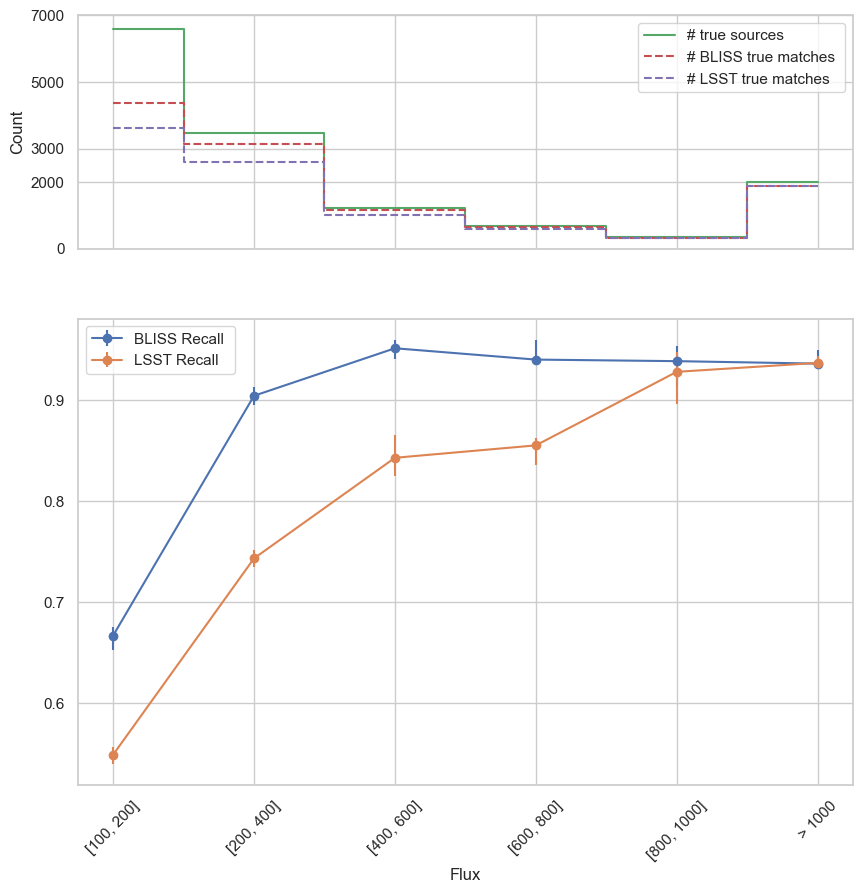

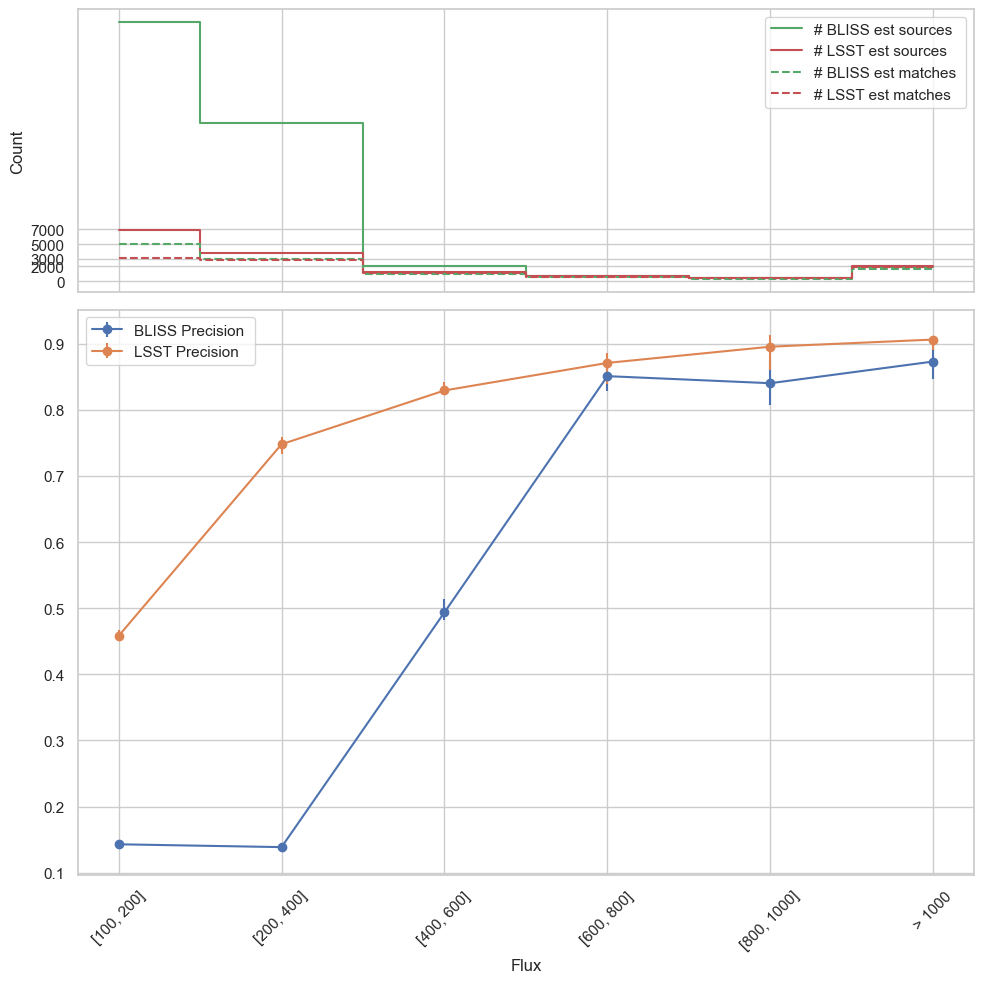

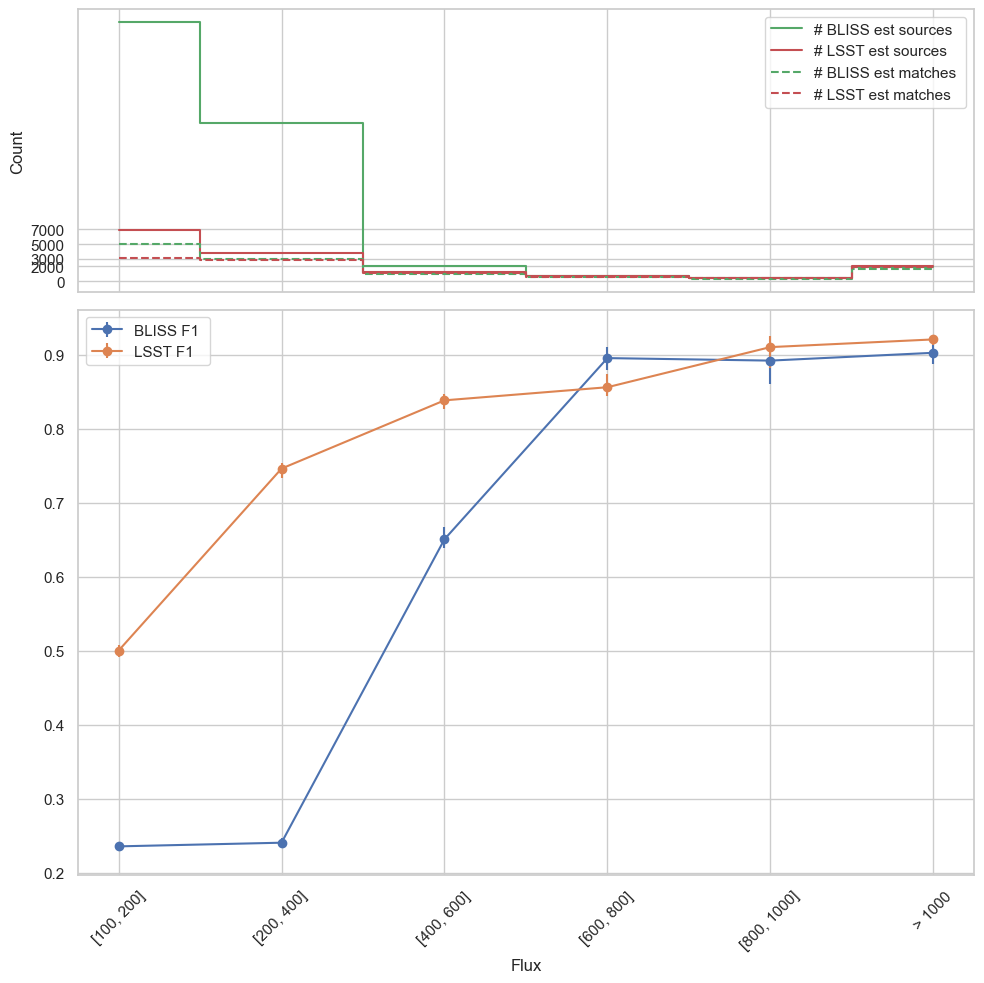

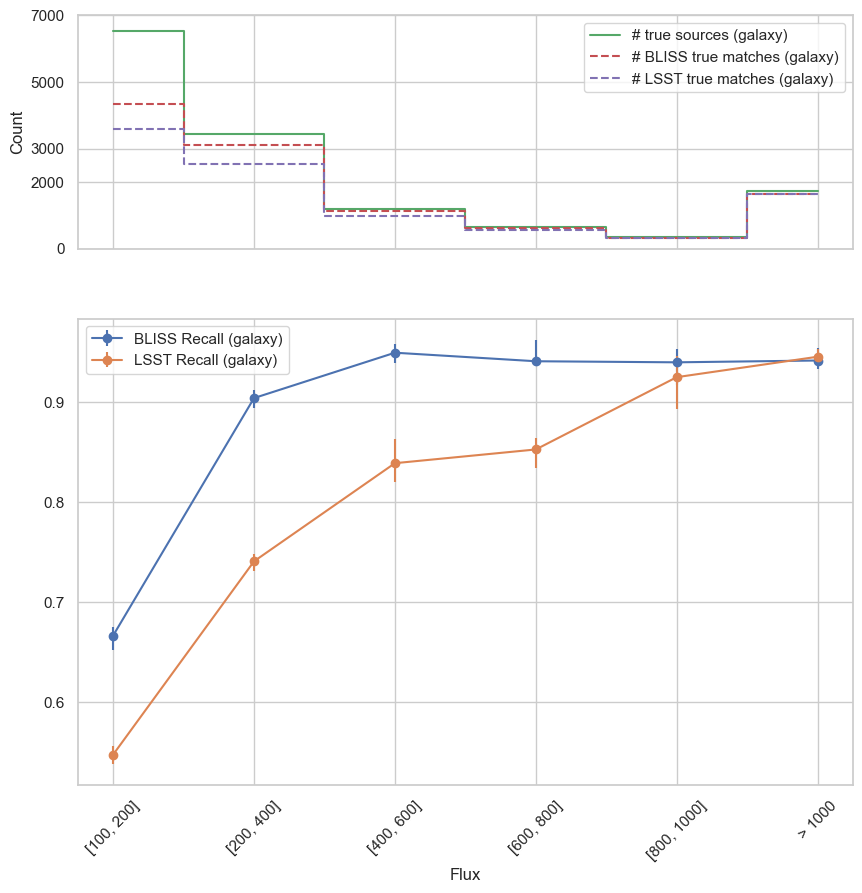

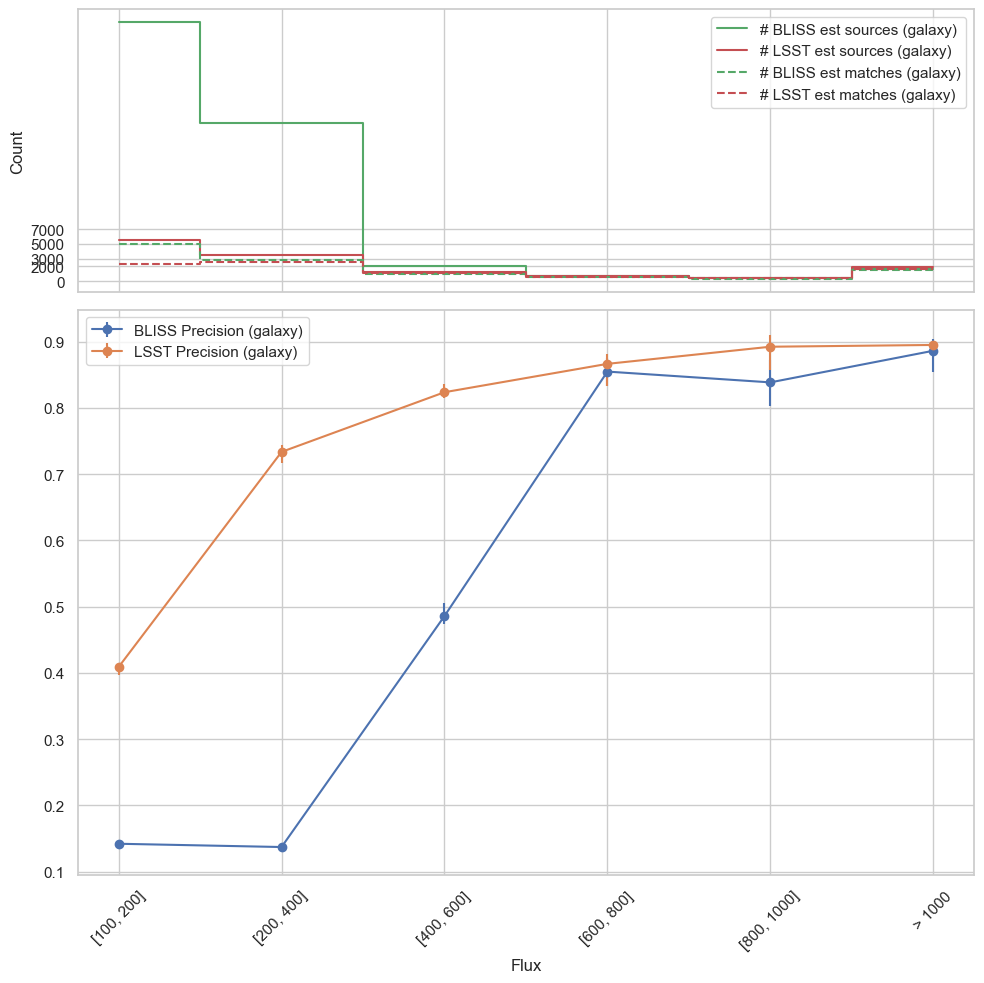

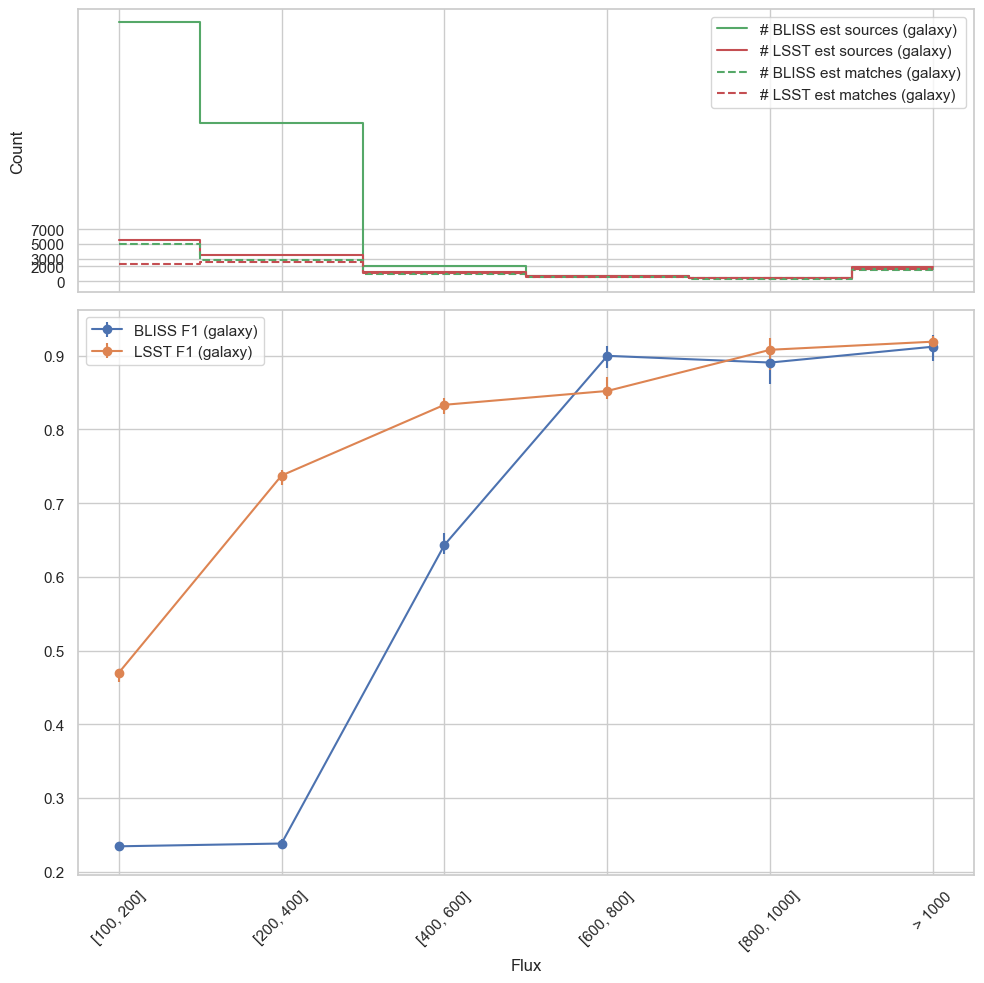

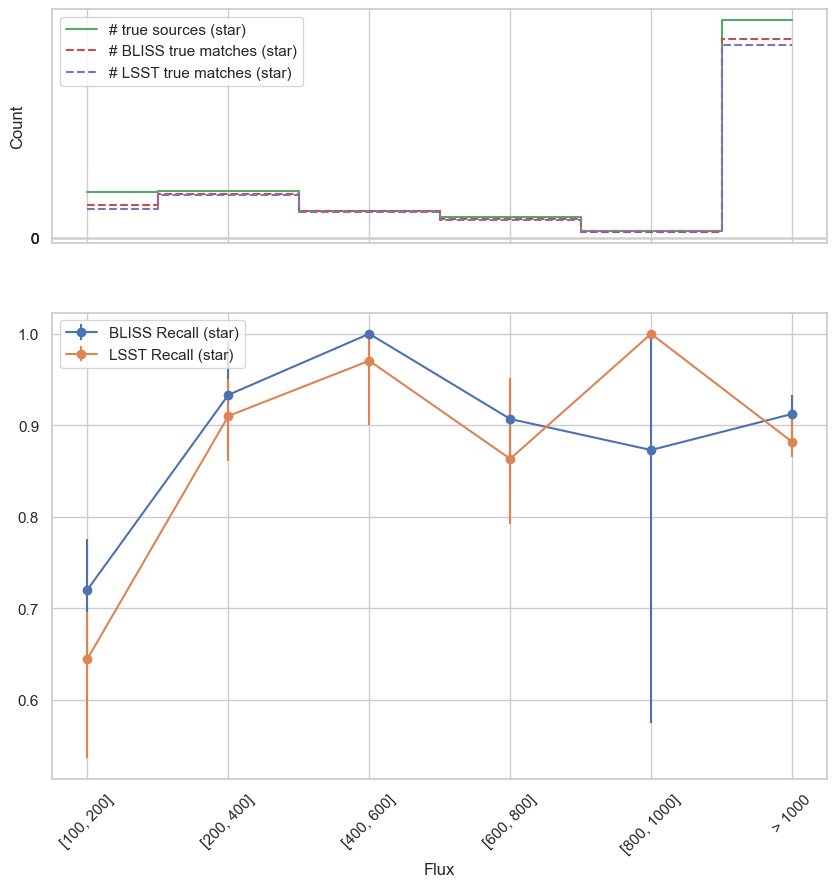

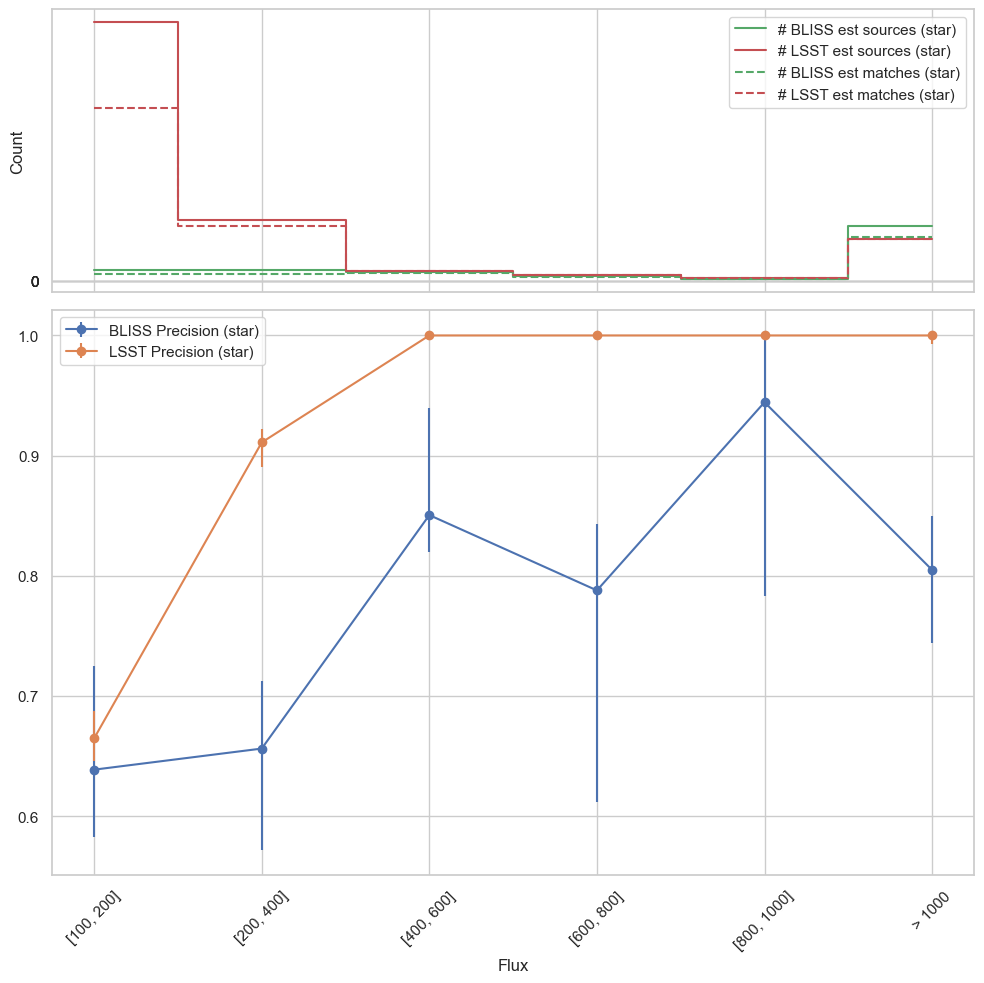

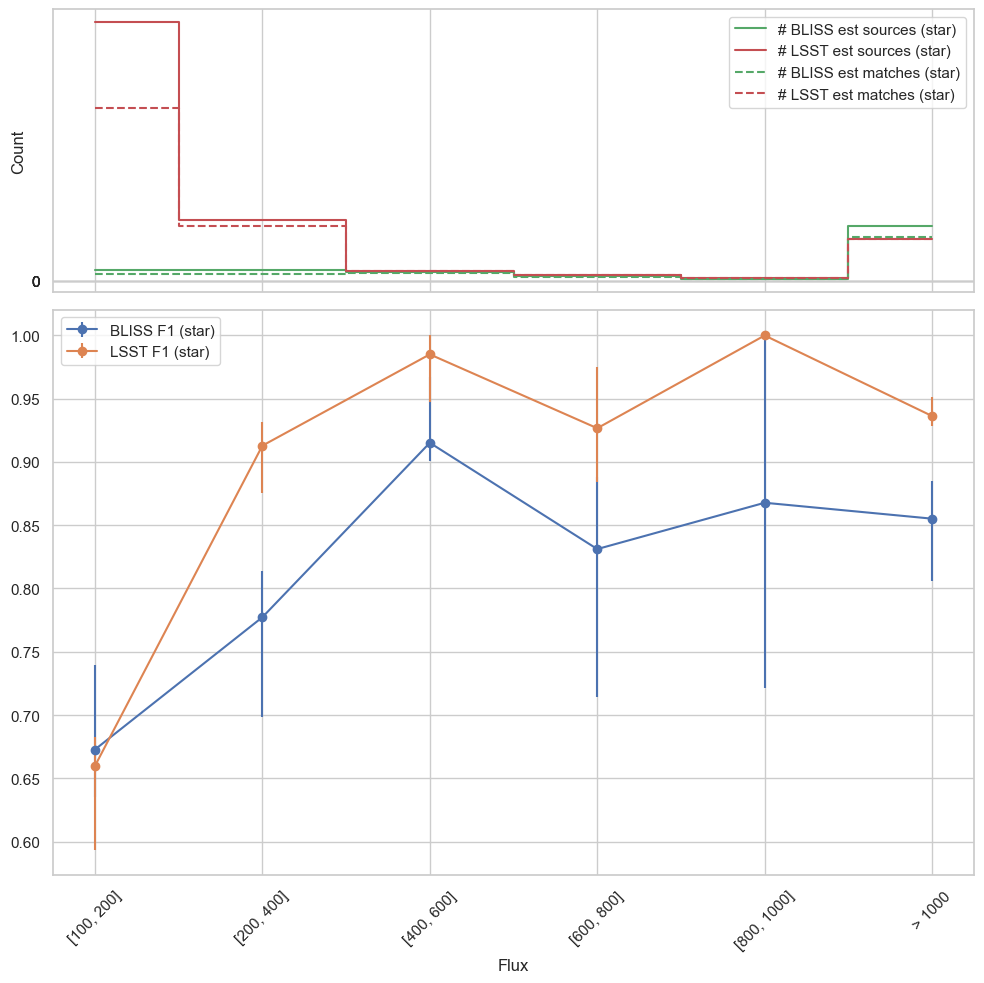

In [6]:
for k, v in bliss_metrics.items():
    bin_cutoffs = v.mag_bin_cutoffs
    postfix_str = v.postfix_str
    recall_fig, precision_fig, f1_fig = plot_with_error_bars(
                                                    bliss_results[f"n_true_sources{postfix_str}"],
                                                    bliss_results[f"n_est_sources{postfix_str}"],
                                                    bliss_results[f"n_true_matches{postfix_str}"],
                                                    bliss_results[f"n_est_matches{postfix_str}"],
                                                    lsst_results[f"n_true_sources{postfix_str}"],
                                                    lsst_results[f"n_est_sources{postfix_str}"],
                                                    lsst_results[f"n_true_matches{postfix_str}"],
                                                    lsst_results[f"n_est_matches{postfix_str}"],
                                                    bin_cutoffs=bin_cutoffs,
                                                    postfix_str=postfix_str,
                                                    model_name_1="BLISS",
                                                    model_name_2="LSST")
    
    recall_fig.savefig(output_dir / f"recall{postfix_str}.pdf", bbox_inches="tight")
    recall_fig.show()
    precision_fig.savefig(output_dir / f"precision{postfix_str}.pdf", bbox_inches="tight")
    precision_fig.show()
    f1_fig.savefig(output_dir / f"f1{postfix_str}.pdf", bbox_inches="tight")
    f1_fig.show()